In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

In [3]:
X, y = make_classification(n_samples=1000, n_features=15, n_informative=10, n_redundant=2,n_clusters_per_class=1, weights=[0.9], flip_y=0, random_state=42)

In [4]:
# Menyusun dataset menjadi DataFrame untuk kemudahan
df = pd.DataFrame(X, columns=[f'Fitur_{i}' for i in range(1, 16)])
df['Target'] = y

# Misalkan kita punya beberapa fitur kategorikal (simulasi fitur kategorikal)
df['Fitur_12'] = np.random.choice(['A', 'B', 'C'], size=1000)
df['Fitur_13'] = np.random.choice(['X', 'Y', 'Z'], size=1000)

df

,Fitur_1,Fitur_2,Fitur_3,Fitur_4,Fitur_5,Fitur_6,Fitur_7,Fitur_8,Fitur_9,Fitur_10,Fitur_11,Fitur_12,Fitur_13,Fitur_14,Fitur_15,Target
0,0.093303,-3.472520,-1.314199,3.525743,0.642138,2.247328,3.067502,1.146301,-2.173112,2.765828,-1.821258,B,Z,1.005559,-0.276558,0
1,-0.189574,-1.770842,-1.578851,-1.372201,-2.025230,0.518655,-0.764750,-3.958705,-0.598147,1.018789,4.194233,C,Y,-0.243630,0.285979,0
2,0.916269,-2.051770,3.631998,0.824844,1.674093,-0.436273,-0.460407,0.031633,-1.140149,2.069694,1.935251,A,Z,2.486020,-2.867291,0
3,-0.914665,-1.608657,-0.735184,-1.742743,-1.753532,0.383412,-1.057937,-2.897416,-0.830328,1.572469,5.334621,B,X,-0.788215,1.255376,0
4,-0.756784,-2.362885,-3.909120,-0.474571,-4.029843,0.947114,0.581146,-3.435229,-2.142380,2.332385,3.816539,A,Z,0.712335,2.810524,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-1.927482,-0.017325,4.884411,0.542628,3.033376,-1.904407,0.953035,1.278882,-1.293396,1.772169,-1.191263,B,Z,-0.387151,-2.629004,0
996,0.347761,-1.690916,5.949207,-2.289729,2.238469,-0.067922,-0.069702,-1.436622,-2.153011,-0.867583,3.962758,B,X,0.886822,-1.248408,0
997,1.201967,-1.263417,-1.331925,-2.468434,1.777577,2.270456,-0.431749,-1.846263,1.753033,1.858452,4.264568,B,Z,0.067260,0.931995,1
998,-2.127846,-0.975838,0.279144,0.151578,-0.443749,0.650616,-1.410265,-1.017319,-0.643070,2.142898,3.399255,B,Z,-0.128774,0.800834,0


In [6]:
# Memisahkan fitur dan target
X = df.drop('Target', axis=1)
y = df['Target']

In [7]:
# Melihat distribusi kelas
print("Distribusi kelas sebelum SMOTE:", Counter(y))

Distribusi kelas sebelum SMOTE: Counter({0: 901, 1: 99})


In [8]:
# ------------------- Embedded Methods -------------------
# Menggunakan Random Forest untuk mendapatkan fitur penting
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
X_integer = X.drop(['Fitur_12', 'Fitur_13'], axis=1)
rf_model.fit(X_integer, y)

# Mendapatkan fitur penting
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Menentukan ambang batas untuk fitur penting
threshold = 0.05  # Misalnya, ambang batas 5%
important_features_indices = [i for i in range(len(importances)) if importances[i] >= threshold]

# Menampilkan fitur penting beserta nilainya
print("Fitur yang dipilih dengan Embedded Methods (di atas ambang batas):")
for i in important_features_indices:
    # Jika X asli berbentuk DataFrame, maka kita ambil nama kolom
    print(f"{X_integer.columns[i]}: {importances[i]}")

# Mendapatkan nama kolom penting berdasarkan importance
important_features = X_integer.columns[important_features_indices]

# Memindahkan fitur penting ke variabel baru
X_important = X_integer[important_features]  # Hanya fitur penting dari data pelatihan

# X_important sekarang berisi hanya fitur penting
print("\nDimensi data pelatihan dengan fitur penting:", X_important.shape)

Fitur yang dipilih dengan Embedded Methods (di atas ambang batas):
Fitur_2: 0.11860019897866206
Fitur_3: 0.06878603593465271
Fitur_5: 0.07731131335837178
Fitur_8: 0.050482655781999855
Fitur_9: 0.2625049418105367
Fitur_10: 0.08958259568334655
Fitur_11: 0.06365230544114515
Fitur_15: 0.12578161860669113

Dimensi data pelatihan dengan fitur penting: (1000, 8)


In [9]:
X_Selected = pd.concat([X_important, X['Fitur_12']], axis=1)
X_Selected = pd.concat([X_Selected, X['Fitur_13']], axis=1)
X_Selected

,Fitur_2,Fitur_3,Fitur_5,Fitur_8,Fitur_9,Fitur_10,Fitur_11,Fitur_15,Fitur_12,Fitur_13
0,-3.472520,-1.314199,0.642138,1.146301,-2.173112,2.765828,-1.821258,-0.276558,B,Y
1,-1.770842,-1.578851,-2.025230,-3.958705,-0.598147,1.018789,4.194233,0.285979,C,Y
2,-2.051770,3.631998,1.674093,0.031633,-1.140149,2.069694,1.935251,-2.867291,B,Z
3,-1.608657,-0.735184,-1.753532,-2.897416,-0.830328,1.572469,5.334621,1.255376,B,Y
4,-2.362885,-3.909120,-4.029843,-3.435229,-2.142380,2.332385,3.816539,2.810524,A,X
...,...,...,...,...,...,...,...,...,...,...
995,-0.017325,4.884411,3.033376,1.278882,-1.293396,1.772169,-1.191263,-2.629004,B,Z
996,-1.690916,5.949207,2.238469,-1.436622,-2.153011,-0.867583,3.962758,-1.248408,A,X
997,-1.263417,-1.331925,1.777577,-1.846263,1.753033,1.858452,4.264568,0.931995,A,X
998,-0.975838,0.279144,-0.443749,-1.017319,-0.643070,2.142898,3.399255,0.800834,B,Y


In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
# Melakukan Encoding untuk fitur 12
X_Selected['Fitur_12'] = label_encoder.fit_transform(X_Selected['Fitur_12'])
# print(label_encoder.inverse_transform(X_Selected[['Fitur_12']]))
# Melakukan Encoding untuk fitur 13
X_Selected['Fitur_13'] = label_encoder.fit_transform(X_Selected['Fitur_13'])
# print(label_encoder.inverse_transform(X_Selected[['Fitur_13']]))

print(X_Selected)

      Fitur_2   Fitur_3   Fitur_5   Fitur_8   Fitur_9  Fitur_10  Fitur_11  \
0   -3.472520 -1.314199  0.642138  1.146301 -2.173112  2.765828 -1.821258   
1   -1.770842 -1.578851 -2.025230 -3.958705 -0.598147  1.018789  4.194233   
2   -2.051770  3.631998  1.674093  0.031633 -1.140149  2.069694  1.935251   
3   -1.608657 -0.735184 -1.753532 -2.897416 -0.830328  1.572469  5.334621   
4   -2.362885 -3.909120 -4.029843 -3.435229 -2.142380  2.332385  3.816539   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.017325  4.884411  3.033376  1.278882 -1.293396  1.772169 -1.191263   
996 -1.690916  5.949207  2.238469 -1.436622 -2.153011 -0.867583  3.962758   
997 -1.263417 -1.331925  1.777577 -1.846263  1.753033  1.858452  4.264568   
998 -0.975838  0.279144 -0.443749 -1.017319 -0.643070  2.142898  3.399255   
999  1.387667 -5.554578 -2.834755 -1.932864  2.625895  0.246120  0.786726   

     Fitur_15  Fitur_12  Fitur_13  
0   -0.276558         1         1  
1  

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Memilih kolom numerik
numeric_columns = X_Selected.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns.drop(['Fitur_12', 'Fitur_13'])

# Membuat salinan data untuk menjaga data asli tetap utuh
X_cleaned = X_important.copy()

In [12]:
for col in numeric_columns:
    # Melihat outlier dengan IQR (Interquartile Range)
    Q1 = X_important[col].quantile(0.25)
    Q3 = X_important[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identifikasi outlier
    outliers = X_cleaned[(X_cleaned[col] < lower_bound) | (X_cleaned[col] > upper_bound)]

    # Menghapus outlier dari DataFrame
    X_cleaned = X_cleaned.drop(outliers.index)
    y = y.drop(outliers.index)

In [13]:
X_cleaned

,Fitur_2,Fitur_3,Fitur_5,Fitur_8,Fitur_9,Fitur_10,Fitur_11,Fitur_15
0,-3.472520,-1.314199,0.642138,1.146301,-2.173112,2.765828,-1.821258,-0.276558
1,-1.770842,-1.578851,-2.025230,-3.958705,-0.598147,1.018789,4.194233,0.285979
2,-2.051770,3.631998,1.674093,0.031633,-1.140149,2.069694,1.935251,-2.867291
3,-1.608657,-0.735184,-1.753532,-2.897416,-0.830328,1.572469,5.334621,1.255376
4,-2.362885,-3.909120,-4.029843,-3.435229,-2.142380,2.332385,3.816539,2.810524
...,...,...,...,...,...,...,...,...
995,-0.017325,4.884411,3.033376,1.278882,-1.293396,1.772169,-1.191263,-2.629004
996,-1.690916,5.949207,2.238469,-1.436622,-2.153011,-0.867583,3.962758,-1.248408
997,-1.263417,-1.331925,1.777577,-1.846263,1.753033,1.858452,4.264568,0.931995
998,-0.975838,0.279144,-0.443749,-1.017319,-0.643070,2.142898,3.399255,0.800834


from matplotlib import pyplot as plt
X_cleaned['Fitur_2'].plot(kind='hist', bins=20, title='Fitur_2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
X_cleaned['Fitur_3'].plot(kind='hist', bins=20, title='Fitur_3')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
X_cleaned['Fitur_5'].plot(kind='hist', bins=20, title='Fitur_5')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
X_cleaned['Fitur_8'].plot(kind='hist', bins=20, title='Fitur_8')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
X_cleaned.plot(kind='scatter', x='Fitur_2', y='Fitur_3', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
X_cleaned.plot(kind='scatter', x='Fitur_3', y='Fitur_5', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
X_cleaned.plot(kind='scatter', x='Fitur_5', y='Fitur_8', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
X_cleaned.plot(kind='scatter', x='Fitur_8', y='Fitur_9', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
X_cleaned['Fitur_2'].plot(kind='line', figsize=(8, 4), title='Fitur_2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
X_cleaned['Fitur_3'].plot(kind='line', figsize=(8, 4), title='Fitur_3')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
X_cleaned['Fitur_5'].plot(kind='line', figsize=(8, 4), title='Fitur_5')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
X_cleaned['Fitur_8'].plot(kind='line', figsize=(8, 4), title='Fitur_8')
plt.gca().spines[['top', 'right']].set_visible(False)

In [14]:
# Inisialisasi SMOTE
smote = SMOTE(random_state=42)

# 3. Melakukan oversampling pada dataset
X_resampled, y_resampled = smote.fit_resample(X_cleaned, y)

# Menampilkan distribusi kelas setelah SMOTE
print("Distribusi kelas setelah SMOTE:", Counter(y_resampled))

# Mengubah hasil menjadi DataFrame untuk visualisasi atau analisis lebih lanjut
X_resampled = pd.DataFrame(X_resampled)
y_resampled = pd.Series(y_resampled, name='Target')

Distribusi kelas setelah SMOTE: Counter({0: 875, 1: 875})


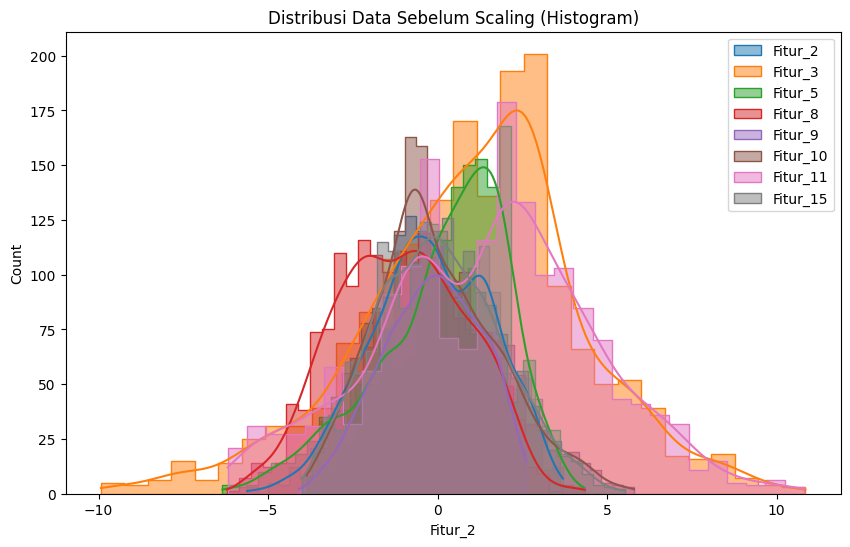

In [15]:
# 1. Visualisasi distribusi data sebelum scaling menggunakan histogram
plt.figure(figsize=(10, 6))
for col in X_resampled.columns:
    sns.histplot(X_resampled[col], kde=True, label=col, bins=30, element='step')
plt.title('Distribusi Data Sebelum Scaling (Histogram)')
plt.legend()
plt.show()

In [16]:
# Scaling: Standarisasi fitur numerik menggunakan StandardScaler
scaler = StandardScaler()

# Melakukan scaling pada fitur penting
X_resampled[important_features] = scaler.fit_transform(X_resampled[important_features])

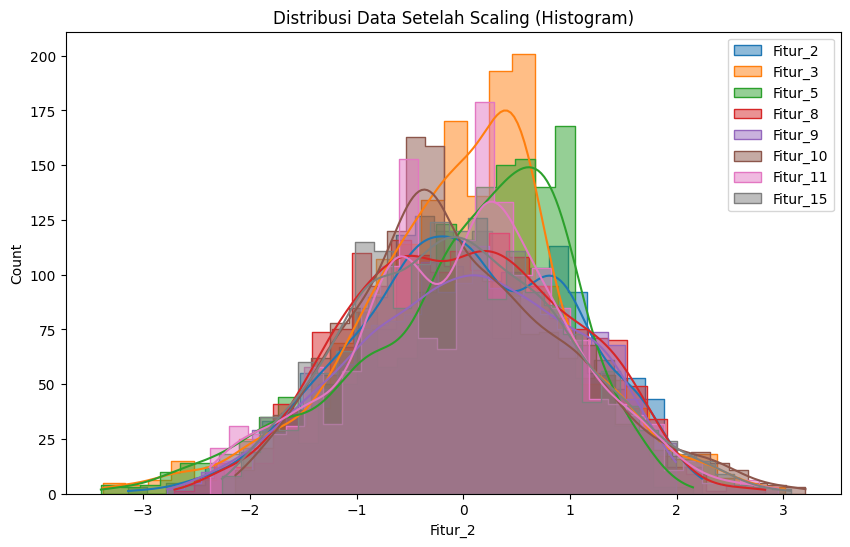

In [17]:
# 1. Visualisasi distribusi data setelah scaling menggunakan histogram
plt.figure(figsize=(10, 6))
for col in X_resampled.columns:
    sns.histplot(X_resampled[col], kde=True, label=col, bins=30, element='step')
plt.title('Distribusi Data Setelah Scaling (Histogram)')
plt.legend()
plt.show()

In [18]:
X_resampled.describe(include='all')

,Fitur_2,Fitur_3,Fitur_5,Fitur_8,Fitur_9,Fitur_10,Fitur_11,Fitur_15
count,1.750000e+03,1.750000e+03,1.750000e+03,1.750000e+03,1.750000e+03,1750.000000,1.750000e+03,1.750000e+03
mean,3.248195e-17,-2.436147e-17,3.248195e-17,-4.060244e-18,3.248195e-17,0.000000,9.744586e-17,-9.744586e-17
std,1.000286e+00,1.000286e+00,1.000286e+00,1.000286e+00,1.000286e+00,1.000286,1.000286e+00,1.000286e+00
min,-3.140254e+00,-3.378635e+00,-3.395160e+00,-2.705454e+00,-2.773574e+00,-2.133851,-2.375105e+00,-2.260982e+00
25%,-6.753646e-01,-6.026534e-01,-5.875147e-01,-7.350120e-01,-7.296781e-01,-0.686312,-6.562131e-01,-7.685301e-01
50%,7.019504e-03,6.064925e-02,1.916188e-01,4.347537e-03,4.743591e-02,-0.156897,9.778137e-02,-3.796866e-02
75%,7.859312e-01,5.800266e-01,7.374792e-01,7.330751e-01,7.741500e-01,0.660824,6.644054e-01,6.967193e-01
max,2.237440e+00,3.015720e+00,2.152233e+00,2.828207e+00,1.990205e+00,3.206305,2.949236e+00,3.067800e+00
